# Very Deep Convolutional Networks for Large-Scale Image Recognition

## Introduction

This notebook is dedicated to the analysis and implementation of the groundbreaking research paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition." The paper, authored by Karen Simonyan and Andrew Zisserman and published in 2015, presents the influential VGG model, a deep convolutional neural network architecture that significantly advanced the field of computer vision and image recognition.

The VGG model is renowned for its simplicity and effectiveness in image classification tasks. It has played a pivotal role in the evolution of deep learning models for computer vision, setting a benchmark for subsequent research in the domain. Understanding the architectural design strategies outlined in this paper is crucial for anyone seeking to delve into state-of-the-art image recognition techniques.

In this notebook, we will dissect the key components of the VGG model and explore the architectural choices made by the authors.

Let's embark on this journey to unravel the VGG model and harness its capabilities for large-scale image recognition tasks.

# CIFAR-10 Dataset

In the original research paper, the authors conducted experiments using a subset of the vast ImageNet dataset, which included over 1.2 million images distributed across 1000 distinct classes.

For the purposes of this project, our primary goal is to thoroughly examine the VggNet architecture and its underlying principles. As a result, we have opted to utilize CIFAR-10, a more manageable dataset that consists of only 10 classes. Each of these classes contains 6000 images. Specifically, we will focus on using 3000 training images per class, 300 validation images per class, and 600 testing images per class. This simplified dataset allows us to comprehensively explore and understand the intricacies of VggNet while also reducing computational requirements.

In [1]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10(root='./data', train=True, download=True, transform=None)
test_data = CIFAR10(root='./data', train=False, download=True, transform=None)

LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = len(LABEL_NAMES)

100%|██████████| 170498071/170498071 [00:01<00:00, 103057189.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import numpy as np

# Get the train targets
train_targets = np.array(train_data.targets)

# Get the train targets
test_targets = np.array(test_data.targets)

In [3]:
# Number of samples per class for the training set
num_train_samples_per_class = 3000

# Number of samples per class for the validation set
num_valid_samples_per_class = 300

# Number of samples per class for the test set
num_test_samples_per_class = 600

In [4]:
train_indices = []
valid_indices = []
test_indices = []

for class_idx in range(NUM_CLASSES):
    # for each class idx
    # get the indices of the samples with the same class

    ### Train indices
    class_indices = np.where(train_targets == class_idx)[0]
    class_train_indices = class_indices[:num_train_samples_per_class]
    train_indices.extend(list(class_train_indices))

    ### Test and Validation indices
    # Note : the test and validation subsets are disjoint
    #      : because the CIFAR-10 test dataset is many times
    #      : greater than our test/validation sets

    class_indices = np.where(test_targets == class_idx)[0]

    # Validation indices
    class_valid_indices = class_indices[:num_valid_samples_per_class]
    valid_indices.extend(list(class_valid_indices))

    # Test indices
    class_test_indices = class_indices[-num_test_samples_per_class:]
    test_indices.extend(list(class_test_indices))

# Sanity check
assert len(train_indices) == NUM_CLASSES * num_train_samples_per_class
assert len(valid_indices) == NUM_CLASSES * num_valid_samples_per_class
assert len(test_indices) == NUM_CLASSES * num_test_samples_per_class

### Test and Validation indices
#   were chosen from the same test set
#   lets make sure they are disjoint

# Disjointness check
assert len(set(test_indices).intersection(set(valid_indices))) == 0

In [5]:
# Get the train, valid and test samples
train_samples = [train_data[i] for i in train_indices]
valid_samples = [test_data[i] for i in valid_indices]
test_samples = [test_data[i] for i in test_indices]

# Delete unnecessary variables
del train_data
del test_data
del train_indices
del valid_indices
del test_indices

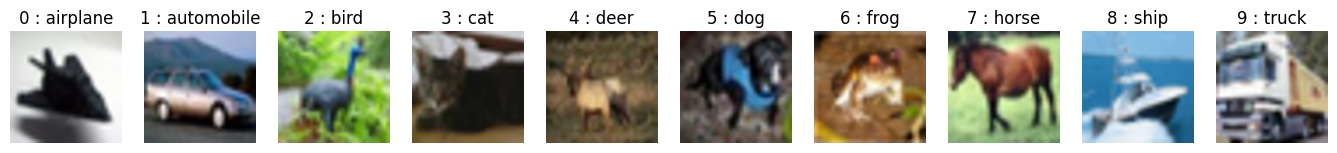

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class customCIFAR(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image, label = sample
        image = image.resize((224, 224))
        image = np.asarray(image) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        return image, label

train_dataset = customCIFAR(train_samples)
valid_dataset = customCIFAR(valid_samples)

# Quick Check

# Visualize one of the images
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 10, figsize=(17, 3))
for i in range(10):
    img, label = train_dataset[i * num_train_samples_per_class]
    img = np.transpose(img, (1, 2, 0))
    axes[i].imshow(np.array(img))
    axes[i].set_title(f"{label} : {LABEL_NAMES[label]}")
    axes[i].axis('off')
plt.show()

## VGGNet

The VGGNet, short for Very Deep Convolutional Networks, introduced several key innovations that significantly advanced the field of image recognition:

1. **Uniform Architecture:** One of the notable features of VGGNet is its uniform architecture. It employed a consistent 3x3 convolutional kernel size throughout the entire network, with max-pooling layers interspersed between convolutional layers. This regularity made the network easy to understand and replicate.

2. **Depth Matters:** VGGNet demonstrated the power of depth in convolutional neural networks. It pushed the boundaries of model depth by introducing deeper networks with 16 to 19 weight layers. This deep architecture showed substantial gains in performance, challenging the conventional wisdom that shallower networks were more practical.

3. **Small Convolution Filters:** VGGNet's distinctive characteristic is the use of small 3x3 receptive fields, convolved with the input at every pixel with a stride of 1. This is in contrast to earlier approaches (Like **AlexNet**) that used larger receptive fields. The use of 3x3 filters provides several advantages, including:

    - **Effective Receptive Field Expansion:** A stack of three 3x3 convolutional layers, without spatial pooling in between, results in an effective receptive field of 7x7. This allows VGGNet to capture complex spatial information effectively.

    - **Increased Non-Linearity:** The use of multiple 3x3 convolutional layers introduces three non-linear rectification layers instead of just one in the case of a single larger receptive field. This increases the model's ability to learn discriminative features.

    - **Parameter Efficiency:** VGGNet reduces the number of parameters compared to using larger receptive fields. A three-layer 3x3 convolution stack with C channels is parametrized by $3\times (3C)^2 = 27 \times C^2$ weights, while a single 7x7 convolution layer would require $(7C)^2 = 49 \times C^2$ parameters, which is 81% more. This parameter efficiency contributes to better regularization and faster training.

5. **Impact on Transfer Learning:** VGGNet's architecture has proven highly transferable. Pre-trained VGG models on large datasets, like ImageNet, have been used as the foundation for various computer vision tasks, making it a valuable tool for transfer learning.

Let's go ahead and implement the Vgg-16 model in PyTorch.

<div align="center">
<img src="./resources/vggnet.jpg" width="900">
</div>

In [7]:
import torch.nn as nn

class Vgg16(nn.Module):
    def __init__(self, num_classes=10):
        super(Vgg16, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(4096, num_classes))

        # Initialize weights using He Initialization
        # to speed up training.
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

In [8]:
from torchsummary import summary

# Create a model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = Vgg16().to(device)

# Visualize a summary of the model
summary(vgg16, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Train

In [9]:
import json
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

def train(model, train_loader, valid_loader, num_epochs, learning_rate, weight_decay, momentum, saving_freq, patience, output_file):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_valid_loss = float('inf')
    no_improvement = 0  # Early stopping counter

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            if batch_idx % 100 == 99:  # Print every 50 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()  # Set the model to evaluation mode
        valid_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        valid_accuracy = accuracy_score(all_targets, all_preds)
        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(valid_accuracy)

        print(f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')

        # Early stopping based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break

        # Save the model every saving_freq epochs
        if (epoch + 1) % saving_freq == 0:
            model_save_name = f'./outputs/model_{epoch + 1}.pt'
            torch.save(model.state_dict(), model_save_name)
            print(f'Saved model as {model_save_name}')

    # Save train and validation scores to a JSON file
    scores = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "valid_accuracies": valid_accuracies
    }

    with open('./outputs/' + output_file, 'w') as json_file:
        json.dump(scores, json_file)

    print('Training finished.')

In [10]:
from torch.utils.data import DataLoader
import os

# Define the train data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Define device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a model instance
vgg16 = Vgg16().to(device)

# Create output folder if it doesn't exist
os.makedirs("outputs", exist_ok=True)

# Training params
num_epochs = 30
learning_rate = 0.005
weight_decay = 0.005
momentum = 0.9

In [11]:
train(
    model = vgg16,
    train_loader = train_loader,
    valid_loader = valid_loader,
    num_epochs = num_epochs,
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    momentum = momentum,
    saving_freq = 5,
    patience = 5,
    output_file = 'metrics.json'
    )

Epoch [1/30], Batch [100/938], Loss: 2.2964
Epoch [1/30], Batch [200/938], Loss: 2.1932
Epoch [1/30], Batch [300/938], Loss: 2.0731
Epoch [1/30], Batch [400/938], Loss: 2.0166
Epoch [1/30], Batch [500/938], Loss: 1.9648
Epoch [1/30], Batch [600/938], Loss: 1.9007
Epoch [1/30], Batch [700/938], Loss: 1.8592
Epoch [1/30], Batch [800/938], Loss: 1.7857
Epoch [1/30], Batch [900/938], Loss: 1.8197
Validation Loss: 1.7261, Validation Accuracy: 0.3647
Epoch [2/30], Batch [100/938], Loss: 1.7284
Epoch [2/30], Batch [200/938], Loss: 1.7270
Epoch [2/30], Batch [300/938], Loss: 1.6500
Epoch [2/30], Batch [400/938], Loss: 1.7139
Epoch [2/30], Batch [500/938], Loss: 1.6240
Epoch [2/30], Batch [600/938], Loss: 1.5749
Epoch [2/30], Batch [700/938], Loss: 1.5754
Epoch [2/30], Batch [800/938], Loss: 1.4978
Epoch [2/30], Batch [900/938], Loss: 1.4483
Validation Loss: 1.4043, Validation Accuracy: 0.4983
Epoch [3/30], Batch [100/938], Loss: 1.3879
Epoch [3/30], Batch [200/938], Loss: 1.3520
Epoch [3/30], 

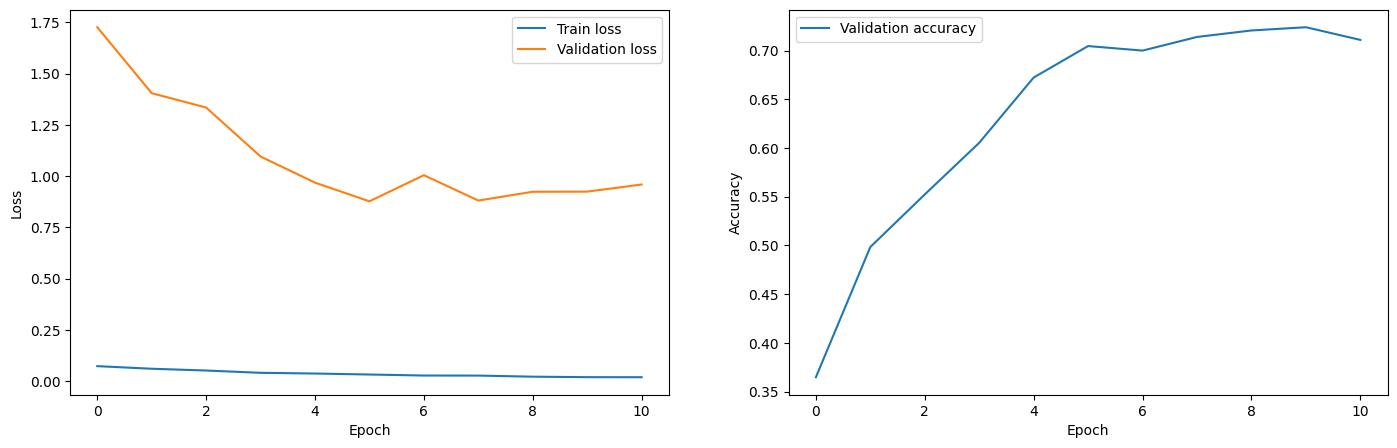

In [12]:
# Visualize the training and validation losses
import json
import matplotlib.pyplot as plt

with open('./outputs/metrics.json') as json_file:
    scores = json.load(json_file)

train_losses = scores['train_losses']
valid_losses = scores['valid_losses']
valid_accuracies = scores['valid_accuracies']

fig, axes = plt.subplots(1, 2, figsize=(17, 5))
axes[0].plot(train_losses, label='Train loss')
axes[0].plot(valid_losses, label='Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot(valid_accuracies, label='Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show()

As observed in the results, a noticeable gap exists between the training and validation losses, indicating a significant difference in the model's performance on these two datasets. The rapid convergence during training is expected, given that the model boasts more than 130 million parameters while being trained on a relatively small dataset (comprising 3000 images per class for 10 classes). This predisposes the model to quickly exhibit signs of overfitting.

In this context, my primary objective centers around comprehending the research paper and implementing the Vgg architecture to gain insight into its advantages. Addressing overfitting is not my primary focus at the moment, but if the need arises, I would consider employing the same data augmentations utilized by the authors of the paper. These augmentations closely align with those employed in the **"ImageNet Classification with Deep Convolutional Neural Networks"** paper. Additionally, I might explore regularization techniques or introduce additional, previously unused data augmentations such as contrast and brightness adjustments.

In [13]:
import torch

# Define a test function
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the same device as inputs

    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)  # Ensure targets are on the same device

            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update counts for correct and total predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


In [14]:
# Define the test data loader
test_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test(vgg16, test_loader)

Test Accuracy: 71.10%


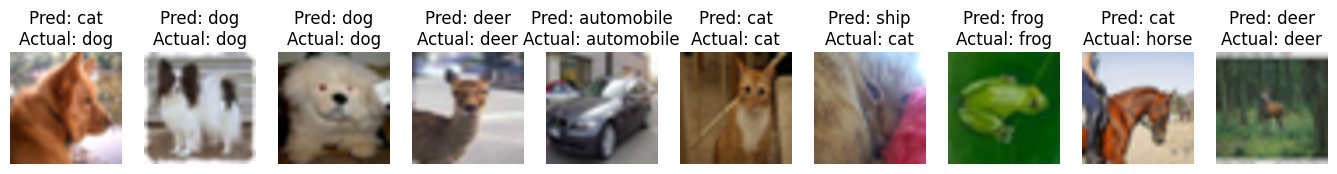

In [18]:
import random

def plot_random_predictions(model, data_loader, label_names, device):
    model.eval()  # Set the model to evaluation mode

    # Get random samples from the data loader
    random_samples = random.sample(range(len(data_loader.dataset)), 10)

    fig, axes = plt.subplots(1, 10, figsize=(17, 3))
    for i, idx in enumerate(random_samples):
        img, label = data_loader.dataset[idx]
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            output = model(img)
        _, predicted = torch.max(output, 1)

        img = img.squeeze().cpu().numpy().transpose((1, 2, 0))  # Convert image back to numpy format
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {label_names[predicted.item()]}\nActual: {label_names[label]}")
        axes[i].axis('off')

    plt.show()

plot_random_predictions(vgg16, test_loader, LABEL_NAMES, device)